## Analysis 1 of 4 for K4K Community Capstone

1) **Describe trends of past donors** <-- this notebook

2) Describe subset of matches, exploiting attributes from PDF dataset (entreprises donatrices)

3) Algorithm: score all companies in PDF based on similarity to matched ones

4) If time, annotate synthetic donate = 0  and try classification model

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [6]:
df = pd.read_pickle('past_donors_clean.pickle')
df = df[df.year != '2022']
print(df.shape)
print(df.columns.values)

print( df.year.min(), df.year.max() )


(1030, 9)
['company' 'added_modified' 'dollar_amount_float' 'moneyprize_received'
 'donation_details' 'year' 'don_detail_amount' 'dollar_equivalent_amount'
 'don_detail_txt']
2010 2021


ideas for charts:

- lineplot: amount donations per year, # distinct companies 

- something to show companies that donate frequently, donation intervals

- companies that have donated most times

- companies that used to donate but not anymore 

- most common donation details, least commong

- trend between donation details and amount donated

- companies that have always donated at similar times of the year 

#### 1. Donations per year
Let's see the total funds raised in the last 10 years, and lets compare it to the amount of distinct donors. Are these 2 connected?

We see that years where the raised funds where highest (2018, 2019), it wasn't through more donors, but actually less companies doing larger donations. Comparatively, a year like 2014 where the donating companies were the highest at around 140, saw one of the lowest funds raised. 

There is strong case to analyze what donors are more helpful than others.

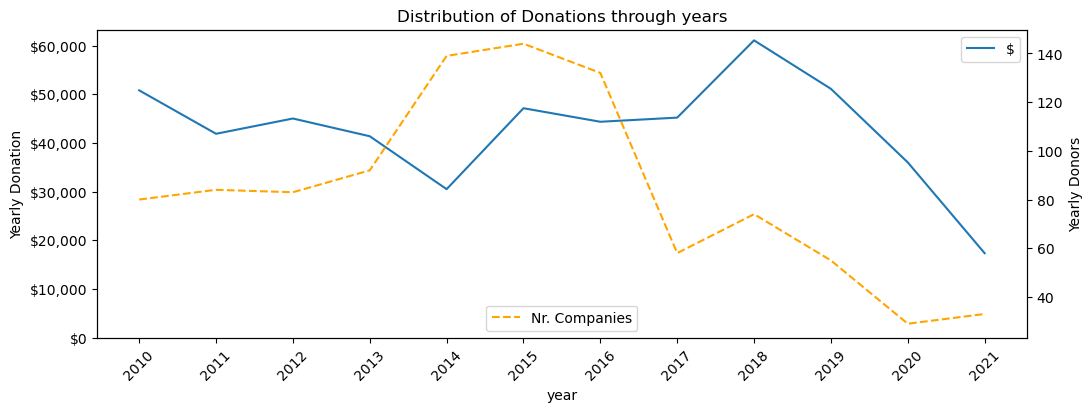

In [4]:
import matplotlib.ticker as mtick


fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)

fig, ax = plt.subplots(1,1, figsize = (12,4))

# line 1: mean donations per year
sns.lineplot(ax = ax, data = df, x = 'year', y = 'dollar_equivalent_amount', estimator = sum, ci = None, label = '$')
# we use dollar_equivalent_amount which rescues some values of non-monetary donations with a valuation of the equivalent

# line 2: we calculate number of companies per year
unq_pr_yr = df.groupby('year')['company'].nunique().reset_index() 
ax2 = ax.twinx()
sns.lineplot(ax = ax2, data = unq_pr_yr, x = 'year', y = 'company', estimator = sum, ci = None, dashes = True, label = 'Nr. Companies')

ax2.lines[0].set_linestyle("--")
ax2.lines[0].set_color('orange')

ax.yaxis.set_major_formatter(tick)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_ylim(bottom=0)
ax.set_title('Distribution of Donations through years')
ax.set_ylabel('Yearly Donation')
ax2.set_ylabel('Yearly Donors')

plt.legend(loc = 'lower center')
plt.show()


#### 2. Donation amount per total donations
Let's see what happens when we group the donors by the total number of times they have donated in the last decade.

There seems to be a slight trend to donate higher sums, on average, for the donors that have donated multiple times. Donors that have donated 3 rounds in total, have contributed $500 each time, versus the $200 average of single-time donors

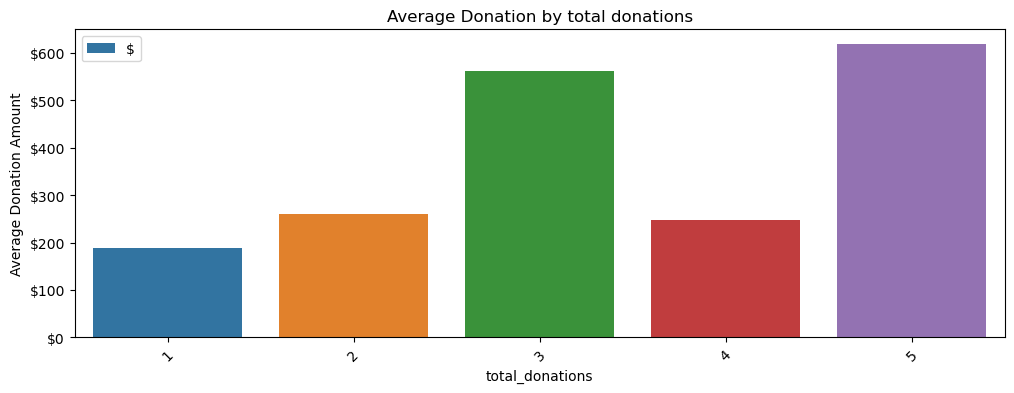

In [5]:

df_grouped = df.groupby('company')['dollar_equivalent_amount'].agg(['mean', 'count']).reset_index()
df_grouped = df_grouped.groupby('count')['mean'].agg(['mean', 'count']).rename_axis(index='total_donations').reset_index().head(5)


import matplotlib.ticker as mtick
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)

fig, ax = plt.subplots(1,1, figsize = (12,4))
#ax2 = ax.twinx()
sns.barplot(ax = ax, data = df_grouped, x = 'total_donations', y = 'mean', estimator = sum, ci = None, label = '$')
#sns.lineplot(ax = ax2, data = df_grouped, x = 'total_donations', y = 'count', estimator = sum, ci = None)


ax2.lines[0].set_linestyle("--")
ax2.lines[0].set_color('orange')

ax.yaxis.set_major_formatter(tick)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_ylim(bottom=0)
ax.set_title('Average Donation by total donations')
ax.set_ylabel('Average Donation Amount')
ax2.set_ylabel('Amount of donors')

ax.legend()
plt.show()


#### 3. Donation amount per round of donation

In part 2 we have discovered that donors that help multiple times, on average, tend to provide higher contributions that single-time donors. Is their donation higher since the start? Or it improves as time goes by and they feel more comfortable donating to K4K? In other words, does the aid get better with each round? 

If we filter the dataset to companies that have donated 5 or more times, we realize that this is clearly the case. For multi-donation companies, the donation amount increases with each contribution. This implies that K4K should be looking to keep their ongoing relationships with donating firms, since they are more likely to receive increasing money from them. 

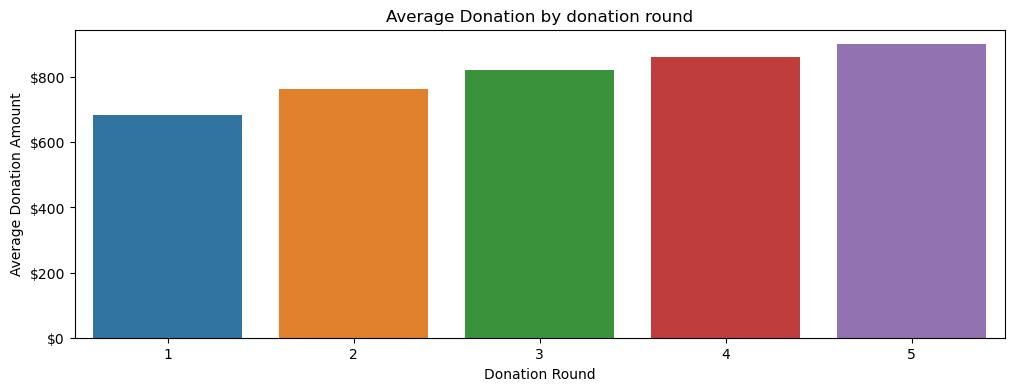

,donation_round,dollar_equivalent_amount
0,1,685.319149
1,2,763.723404
2,3,820.914894
3,4,862.787234
4,5,900.851064


In [17]:
df_grouped['rel_freq'] = df_grouped['count']*100 /df_grouped['count'].sum()
df.loc[:, 'donation_round'] = df.sort_values('added_modified').groupby('company')['company'].cumcount() + 1
freq_comps = df.loc[df.donation_round == 5 , 'company'].drop_duplicates().values
df_freq = df.loc[ (df.donation_round <= 5) & (df.company.isin(freq_comps))]
#df_freq.groupby('donation_round')['dollar_equivalent_amount'].mean().plot()

fig, ax = plt.subplots(1,1, figsize = (12,4))

sns.barplot(ax = ax, data = df_freq, x = 'donation_round', y = 'dollar_equivalent_amount', estimator = np.mean, ci = None)

ax.yaxis.set_major_formatter(tick)
ax.set_ylim(bottom=0)
ax.set_title('Average Donation by donation round')
ax.set_ylabel('Average Donation Amount')
ax.set_xlabel('Donation Round')

plt.show()

df_freq.groupby('donation_round')['dollar_equivalent_amount'].mean().reset_index()

#### 4. Analyzing the consecutiveness of multi-donors

Let's see if multi-donors are donating in back-to-back years or leaving gaps in between. What kind of behavior is a predictor of higher chances of staying as donor for longer?

After analyzing 45 multi-donor companies (5 donations or more) in the data we see that most of them (66%) are back-to-back year donors, meaning they never skipped a year during their period as donors. The rest of companies (33%) have skipped some years of donation. This implies that after stopping to donate for a year, the company becomes less likely to donate the following years. So K4K should really focus on the continuity of donations coming from the multi-donor companies to avoid any losses of future financial aid. 

K4K also has the opportunity to reach out to companies that used to be regulars:

AIR FRANCE [2010, 2011, 2014, 2015, 2016, 2017, 2018]

BMA [2011, 2014, 2015, 2016, 2019]

CN [2011, 2015, 2016, 2016, 2017, 2017, 2018, 2018, 2018, 2019, 2019, 2019]

CN RAILROADERS IN THE COMMUNITY [2015, 2016, 2016, 2017, 2017, 2018, 2018, 2019]

DELTA [2010, 2011, 2011, 2012, 2012, 2013, 2014, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

DR MAURICE TAPIERO [2010, 2011, 2012, 2016, 2017, 2018, 2019]

EMPIRE [2010, 2012, 2013, 2013, 2014, 2015]

ENVIROMARK [2010, 2011, 2012, 2013, 2015, 2016, 2017, 2018]

ERNEST [2010, 2011, 2012, 2014, 2015]

FONDATION BBB [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2018]

M L FORAND COURTIERS D ASSURANCE [2016, 2017, 2018, 2019, 2021]

MARVIN A DRIMER FOUNDATION [2012, 2013, 2015, 2016, 2017, 2018, 2019, 2021]

NAKISA [2010, 2011, 2013, 2018, 2019, 2020, 2021]

PERFORMANCE BROOMS [2010, 2011, 2012, 2013, 2014, 2016, 2017, 2018, 2019, 2020, 2021]

THISTLE [2010, 2011, 2012, 2013, 2014, 2014, 2015, 2016, 2017, 2018]

WESTDENT [2015, 2015, 2016, 2018, 2020, 2021]

In [39]:
freq_comps = df.loc[df.donation_round >= 5 , 'company'].drop_duplicates().values
df_freq = df.loc[(df.company.isin(freq_comps))]
df_years = df_freq.groupby('company')['year'].agg(list).reset_index()

df_years.head(10)

,company,year
0,AIR FRANCE,"[2010, 2011, 2014, 2015, 2016, 2017, 2018]"
1,AUBRY,"[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]"
2,BDO,"[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]"
3,BMA,"[2011, 2014, 2015, 2016, 2019]"
4,BMR OSTIGUY FRERES,"[2011, 2012, 2013, 2014, 2015, 2016]"
5,BOVET,"[2010, 2011, 2012, 2013, 2014]"
6,CITY OF DORVAL,"[2010, 2011, 2012, 2013, 2014]"
7,CN,"[2011, 2015, 2016, 2016, 2017, 2017, 2018, 201..."
8,CN RAILROADERS IN THE COMMUNITY,"[2015, 2016, 2016, 2017, 2017, 2018, 2018, 2019]"
9,COLDWATER,"[2010, 2011, 2012, 2013, 2014]"


In [40]:
b2b_donors = []


t = 0
for i,x in enumerate(df_years.iterrows()):
    x = x[1]
    company = x['company']
    years = [int(n) for n in x['year']]

    min_year = min(years)
    max_year = max(years)

    if years == list(range(min_year, max_year+1)):
        t += 1
        b2b_donors.append(company)
    else:
        print(company, years)


AIR FRANCE [2010, 2011, 2014, 2015, 2016, 2017, 2018]
BMA [2011, 2014, 2015, 2016, 2019]
CN [2011, 2015, 2016, 2016, 2017, 2017, 2018, 2018, 2018, 2019, 2019, 2019]
CN RAILROADERS IN THE COMMUNITY [2015, 2016, 2016, 2017, 2017, 2018, 2018, 2019]
DELTA [2010, 2011, 2011, 2012, 2012, 2013, 2014, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
DR MAURICE TAPIERO [2010, 2011, 2012, 2016, 2017, 2018, 2019]
EMPIRE [2010, 2012, 2013, 2013, 2014, 2015]
ENVIROMARK [2010, 2011, 2012, 2013, 2015, 2016, 2017, 2018]
ERNEST [2010, 2011, 2012, 2014, 2015]
FONDATION BBB [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2018]
M L FORAND COURTIERS D ASSURANCE [2016, 2017, 2018, 2019, 2021]
MARVIN A DRIMER FOUNDATION [2012, 2013, 2015, 2016, 2017, 2018, 2019, 2021]
NAKISA [2010, 2011, 2013, 2018, 2019, 2020, 2021]
PERFORMANCE BROOMS [2010, 2011, 2012, 2013, 2014, 2016, 2017, 2018, 2019, 2020, 2021]
THISTLE [2010, 2011, 2012, 2013, 2014, 2014, 2015, 2016, 2017, 2018]
WESTDENT [2015, 2015, 2016, 2018,

#### 5.Pareto Analysis

Lets find the largest donors each year and see how much the represented of the total yearly raised funds. Then lets see if the top donors tend to repeat to find out if there is an underlying list of priority donors.

We discover that every year, there is a small number of donors (around 10 to 20 percent of the year list) which account for approximately 60% of the raised funds, or sometimes even more. For example, in 2019, only the 9 top donors brought 70.5% of the raised money. K4K should treat this companies as their "top donors" and be very considerate with they thank-you recognitions.

We also see that there is indeed a lot of overlap in the top donating companies in the last years. Organizations such as Fondation BBB or Sunday Curling Gang have been the top corporate donors for K4K in more than 7 times in the last 10 years. 

In [46]:
df_pareto =df[df.dollar_equivalent_amount > 0].copy()

In [47]:
df_pareto = df_pareto.sort_values(['year', 'dollar_equivalent_amount'], ascending=False).reset_index()

In [48]:
def pareto_per_year(df, years = ['2010', '2017', '2019'], q=5, verbose = True):
    top_donors_dcs = []
    for y in years:

        df_pareto =df.loc [(df.dollar_equivalent_amount > 0) & (df.year ==y)].copy().reset_index()
        df_pareto['quintile']= 5-pd.qcut(df_pareto.dollar_equivalent_amount, q = q, duplicates='drop', labels = False )

        df_p_g = df_pareto.groupby('quintile')['dollar_equivalent_amount'].agg(['sum', 'count']).reset_index()
        df_p_g['rel_sum']=df_p_g['sum'].div(df_p_g['sum'].sum() )*100
        df_p_g['rel_size']=df_p_g['count'].div(df_p_g['count'].sum() )*100

        r = df_p_g.nsmallest(1, 'quintile').to_dict('records')[0]    
        top_donors = df_pareto.loc[ df_pareto.quintile == df_pareto.quintile.min(), 'company' ].drop_duplicates().to_list()

        if verbose:
            print( f'''{y}: {r['count']} companies ({np.around(r['rel_size'],2)} of total) donated {np.around(r['rel_sum'],2)} of all the funds raised.''' ) 
        
        top_donors_dcs.append( {y : top_donors} )

    return top_donors_dcs

In [49]:
top_donors = pareto_per_year(df, years = df.year.drop_duplicates().to_list())

2010: 6 companies (11.76 of total) donated 76.31 of all the funds raised.
2011: 7 companies (10.94 of total) donated 63.49 of all the funds raised.
2012: 11 companies (19.64 of total) donated 74.19 of all the funds raised.
2013: 11 companies (18.03 of total) donated 69.48 of all the funds raised.
2014: 9 companies (15.25 of total) donated 56.59 of all the funds raised.
2015: 13 companies (11.5 of total) donated 60.72 of all the funds raised.
2016: 11 companies (16.92 of total) donated 66.93 of all the funds raised.
2017: 8 companies (15.69 of total) donated 61.15 of all the funds raised.
2018: 11 companies (17.19 of total) donated 65.15 of all the funds raised.
2019: 9 companies (20.45 of total) donated 70.5 of all the funds raised.
2020: 3 companies (14.29 of total) donated 64.27 of all the funds raised.
2021: 3 companies (16.67 of total) donated 60.46 of all the funds raised.


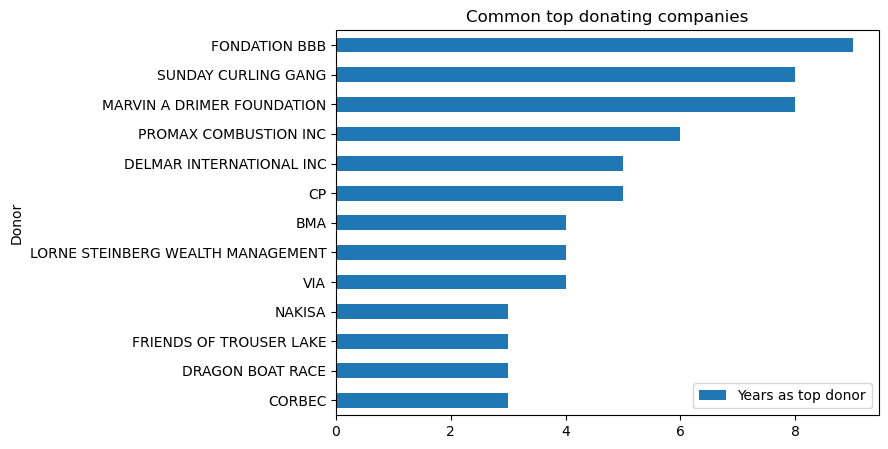

In [50]:
top_donors_list = []

for i in top_donors:
    top_donors_list.extend(list(i.values())[0])

df_td1 = pd.Series(top_donors_list).value_counts().rename_axis(index = 'Donor').reset_index().rename(columns={0:'Years as top donor'})
df_td1 = df_td1.loc[lambda x: x['Years as top donor']>2]

df_td1.set_index('Donor').sort_values('Years as top donor').plot(kind = 'barh', figsize = (7,5), title='Common top donating companies')
plt.show()

#### 6. Donation details

By now we have studied most of the information available in the past donors dataset, expect "donation details". Lets generate a couple of views about it. 

After cleaning and standarizing text, we notice that there are 4-5 very common donation detail descriptions:
Donation, business card, 1/4 page ad, 1/2 page ad

We can also sort them by the average donation amount they tend to represent. Where we notice "corporate team" is the most valuable type of donation, followed by "donation", "K4K friend". 

In [51]:
df.don_detail_txt.value_counts(1).loc[lambda x: x>0.01]*100
# most common donations received

donation            9.725159
business card       9.302326
1/4 page ad         8.562368
1/2 page ad         3.805497
business card ad    3.488372
corporate team      2.959831
k4k friend          2.431290
silver              2.008457
busines card        1.162791
thank you page      1.162791
Name: don_detail_txt, dtype: float64

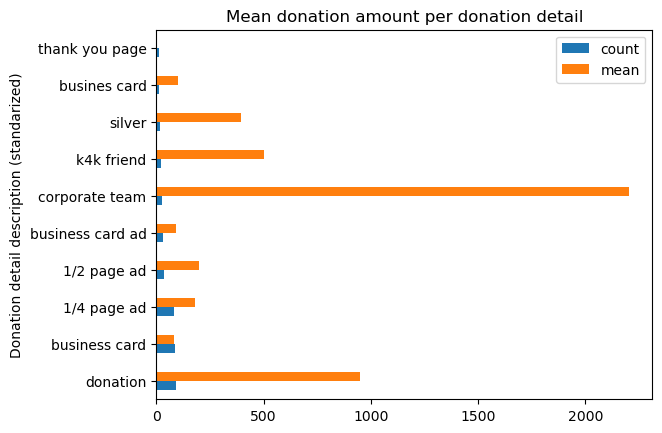

In [60]:
# most common donation descriptions, where we see that certain ones stand out 

ax = df.groupby('don_detail_txt')['dollar_equivalent_amount'].agg(['count','mean'])\
    .loc[lambda x: x['count'] >10].sort_values('count', ascending=False)\
    .plot(kind='barh', title = 'Mean donation amount per donation detail')

ax.set_ylabel('Donation detail description (standarized)')
plt.show()